# imports & setup

In [1]:
import importlib
import logging
import os
from pprint import pprint

import dask
import dask.dataframe as dd
import helpers
import numpy as np
import pandas as pd
import scipy.stats
from cloudpathlib import AnyPath as Path
from helpers.pseudobulk_evaluation import deg_analysis

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
handler = logging.StreamHandler()
formatter = logging.Formatter(
    "%(asctime)s %(process)d/%(threadName)s %(name)s %(levelname)s\n%(message)s"
)
handler.setFormatter(formatter)
logging.getLogger().handlers = [handler]

In [4]:
logging.getLogger("gcsfs").setLevel("INFO")
logging.getLogger("google.cloud.bigquery").setLevel("DEBUG")
logging.getLogger("helpers").setLevel("DEBUG")
logging.getLogger("helpers.pseudobulk_evaluation.deg_analysis").setLevel("INFO")
logging.getLogger("pandas").setLevel("DEBUG")
logging.getLogger("pyarrow").setLevel("DEBUG")

In [5]:
logger = logging.getLogger(__name__)
logger.setLevel("DEBUG")
logger.debug("test debug-level message")

2022-07-17 21:35:02,175 3565/MainThread __main__ DEBUG
test debug-level message


# load bulk RNA-seq TPM data

## TCGA SKCM (real)

In [6]:
uri_tcga_skcm_bulk_rnaseq = (
    "gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/"
    "mixtures_real_tcga_skcm/tpm.parquet"
)

In [7]:
ddf_tcga_skcm_bulk_rnaseq = dd.read_parquet(uri_tcga_skcm_bulk_rnaseq, engine="pyarrow")
logger.debug(ddf_tcga_skcm_bulk_rnaseq.dtypes)

2022-07-17 21:35:03,739 3565/MainThread __main__ DEBUG
gene_symbol        category
aliquot_barcode    category
tpm                 float64
dtype: object


In [8]:
ddf_tcga_skcm_bulk_rnaseq

Dask DataFrame Structure:
                     gene_symbol    aliquot_barcode      tpm
npartitions=1                                               
               category[unknown]  category[unknown]  float64
                             ...                ...      ...
Dask Name: read-parquet, 1 tasks

## pseudobulks

In [9]:
uri_pseudobulk_rnaseq = (
    "gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/"
    "mixtures/n_cells=5/malignant_from_one_sample=True/data.parquet"
)

In [10]:
ddf_pseudobulk_rnaseq = (
    dd.read_parquet(
        uri_pseudobulk_rnaseq,
        engine="pyarrow",
    )
    .replace({"malignant_from_one_sample": {"True": True, "False": False}})
    .astype({"n_cells": "uint8", "malignant_from_one_sample": "bool"})
    .rename(columns={"tcga_aliquot_barcode_for_fractions": "aliquot_barcode"})
)

logger.debug(ddf_pseudobulk_rnaseq.dtypes)

2022-07-17 21:35:04,169 3565/MainThread __main__ DEBUG
gene_symbol                  category
aliquot_barcode              category
tpm                           float64
n_cells                         uint8
malignant_from_one_sample        bool
dtype: object


In [11]:
ddf_pseudobulk_rnaseq

Dask DataFrame Structure:
                     gene_symbol    aliquot_barcode      tpm n_cells malignant_from_one_sample
npartitions=1                                                                                 
               category[unknown]  category[unknown]  float64   uint8                      bool
                             ...                ...      ...     ...                       ...
Dask Name: rename, 4 tasks

# analysis

In [12]:
logging.getLogger("helpers.pseudobulk_evaluation.deg_analysis").setLevel(
    "INFO"
)  # DEBUG is loud

In [13]:
df_sample_metadata = deg_analysis.get_tcga_skcm_metastatic_sample_metadata()

2022-07-17 21:35:04,192 3565/MainThread helpers.datasets DEBUG
loading TCGA SKCM fractions estimated by CIBERSORTx
Downloading:   0%|          | 0/369 [00:00<?, ?rows/s]2022-07-17 21:35:06,034 3565/MainThread google.cloud.bigquery._pandas_helpers DEBUG
Started reading table 'keen-dispatch-316219._37d4cdf3349bb7a5059aac014cff35ac3e47f49a.anon963500c015ce7e85114c37e4791af2a8546dee82' with BQ Storage API session 'projects/keen-dispatch-316219/locations/us/sessions/CAISDGw1dmlBbFBBZGlCZRoCamYaAmpk'.
Downloading: 100%|██████████| 369/369 [00:01<00:00, 293.60rows/s]


In [14]:
df_gene_stats_tcga_skcm = deg_analysis.compute_all_deg_results(
    ddf_tcga_skcm_bulk_rnaseq, df_sample_metadata
)

df_gene_stats_pseudobulks = deg_analysis.compute_all_deg_results(
    ddf_pseudobulk_rnaseq, df_sample_metadata
)

In [15]:
df_gene_stats_tcga_skcm.info(), df_gene_stats_pseudobulks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16063 entries, 0 to 16062
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   gene_symbol                      16063 non-null  category
 1   pval                             16063 non-null  float64 
 2   fold_change                      16063 non-null  float64 
 3   -log10_pval                      16063 non-null  float64 
 4   log2_fold_change                 16063 non-null  float64 
 5   -log10_pval_signed               16063 non-null  float64 
 6   pval_adj_fdr=0.05                16063 non-null  float64 
 7   -log10_pval_adj_fdr=0.05         16063 non-null  float64 
 8   -log10_pval_adj_fdr=0.05_signed  16063 non-null  float64 
 9   pval_adj_fdr=0.10                16063 non-null  float64 
 10  -log10_pval_adj_fdr=0.10         16063 non-null  float64 
 11  -log10_pval_adj_fdr=0.10_signed  16063 non-null  float64 
 12  pval

(None, None)

# plots

In [17]:
import plotly.express as px

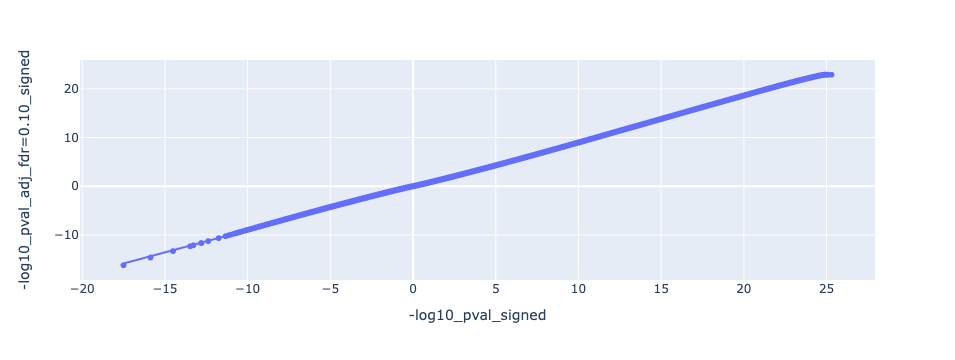

In [19]:
fig = px.scatter(
    df_gene_stats_tcga_skcm,
    x="-log10_pval_signed",
    y="-log10_pval_adj_fdr=0.10_signed",
    trendline="ols",
)
fig.show()

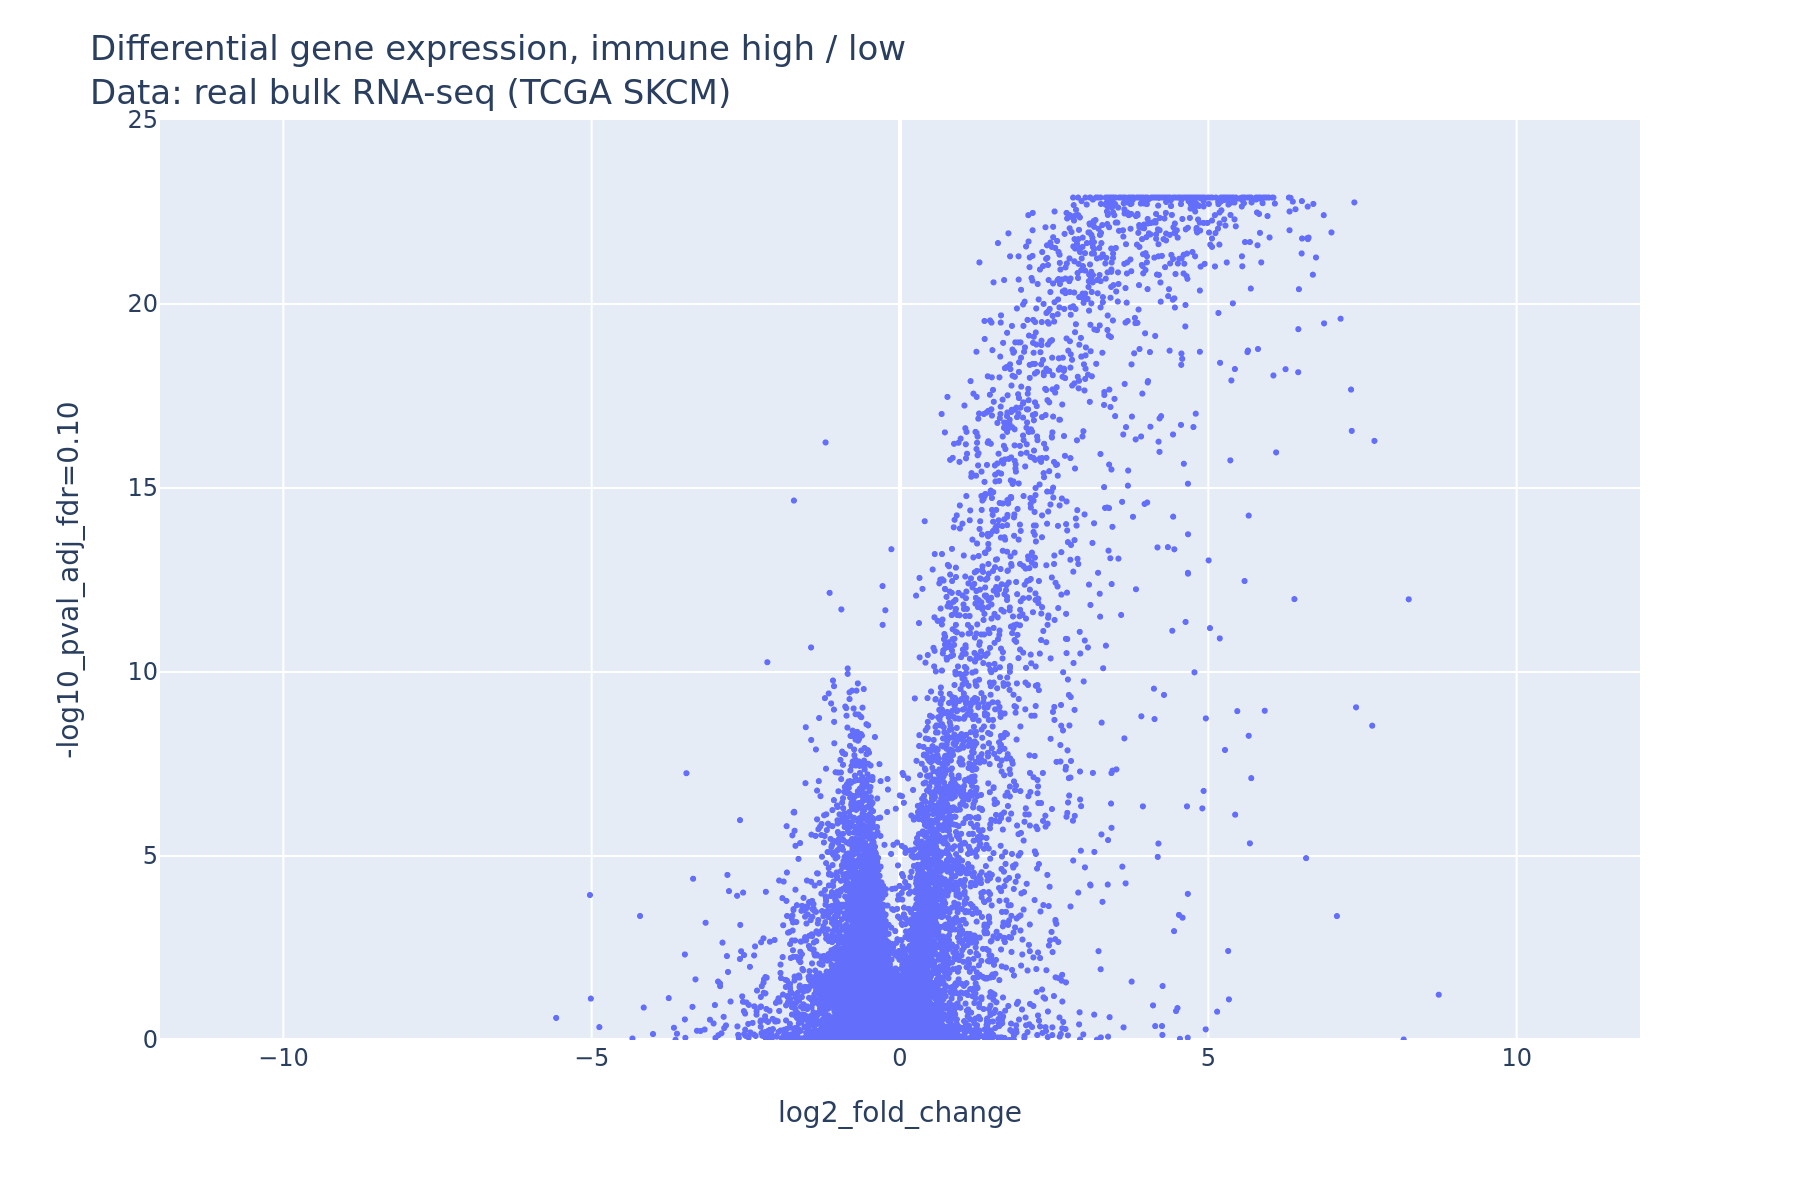

In [20]:
importlib.reload(deg_analysis)

fig = deg_analysis.make_volcano_plot(df_gene_stats_tcga_skcm)

fig.update_layout(
    title=(
        "Differential gene expression, immune high / low"
        "<br>Data: real bulk RNA-seq (TCGA SKCM)"
    ),
)

fig.show(renderer="png", scale=2, width=900, height=600)

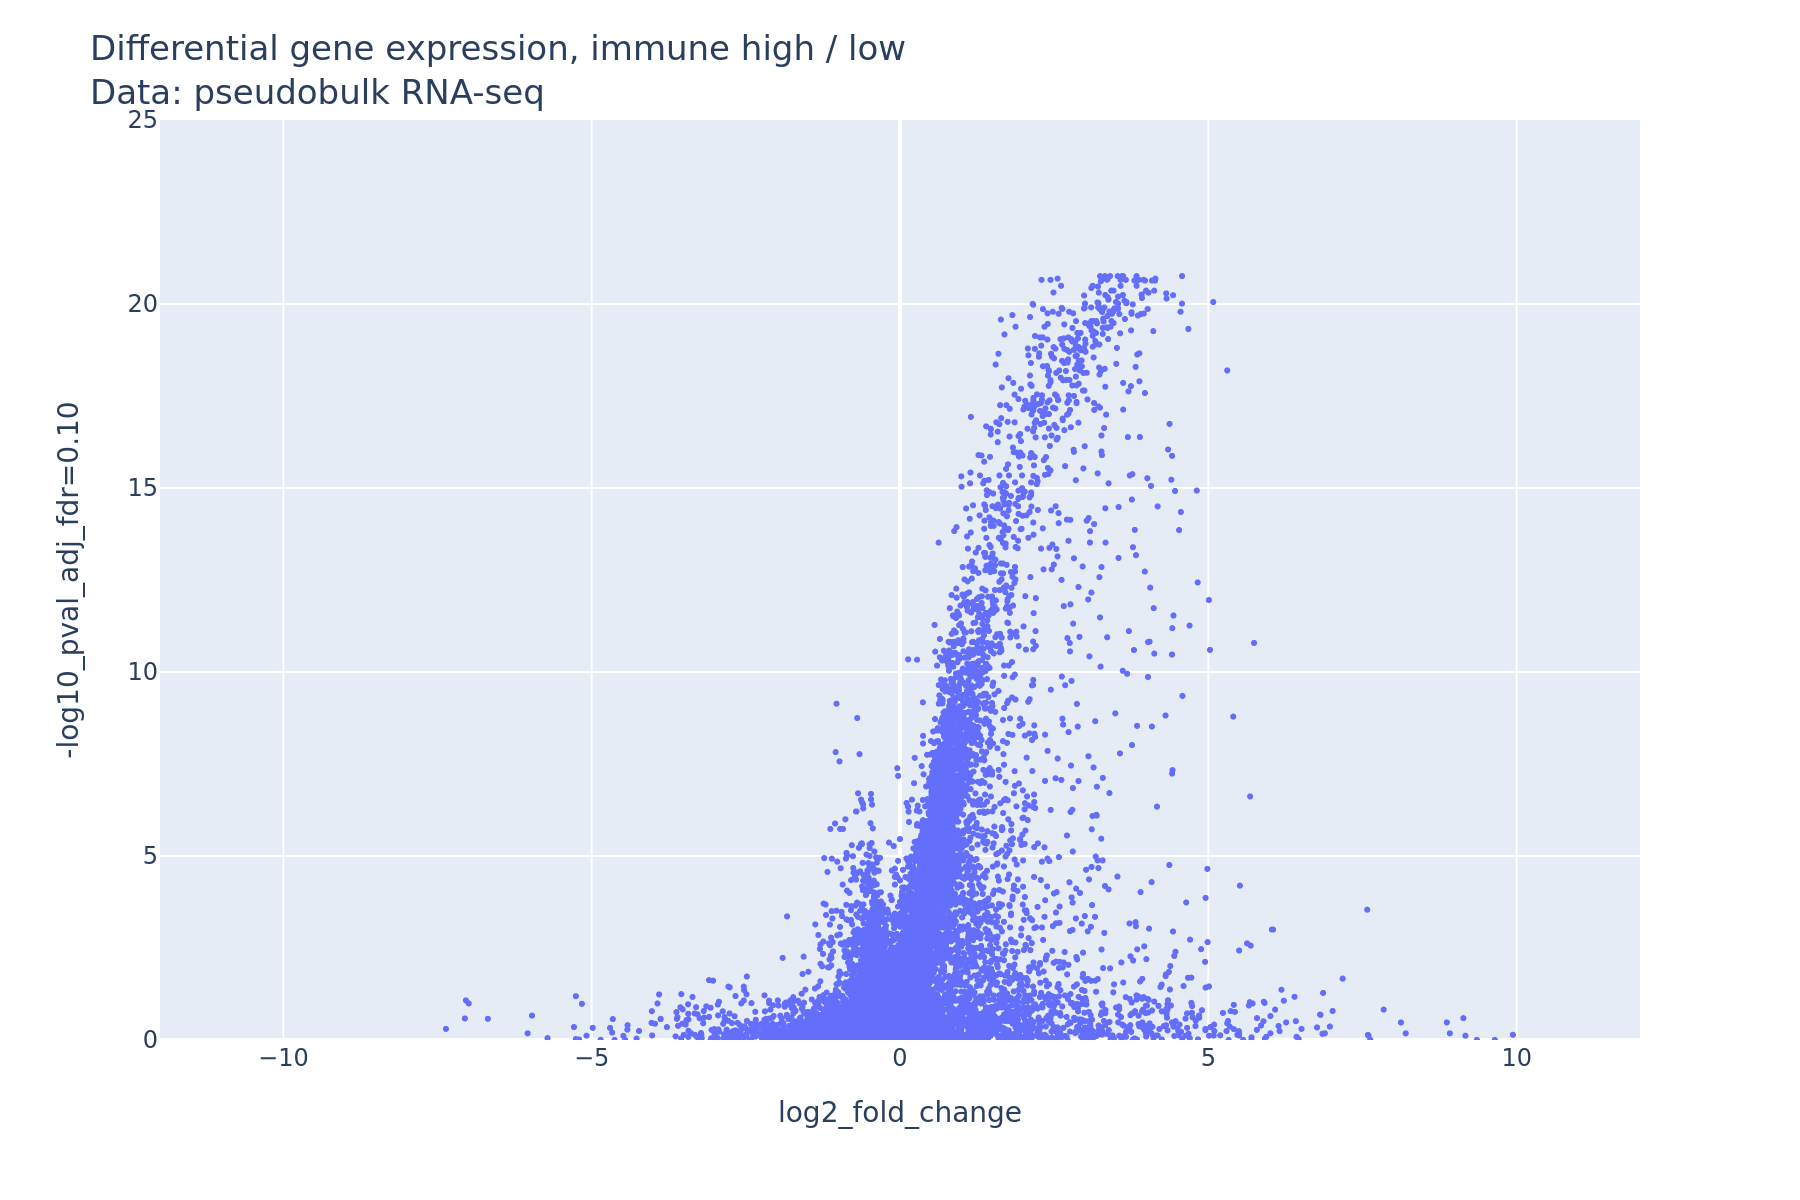

In [21]:
importlib.reload(deg_analysis)

fig = deg_analysis.make_volcano_plot(df_gene_stats_pseudobulks)

fig.update_layout(
    title=(
        "Differential gene expression, immune high / low" "<br>Data: pseudobulk RNA-seq"
    ),
)

fig.show(renderer="png", scale=2, width=900, height=600)

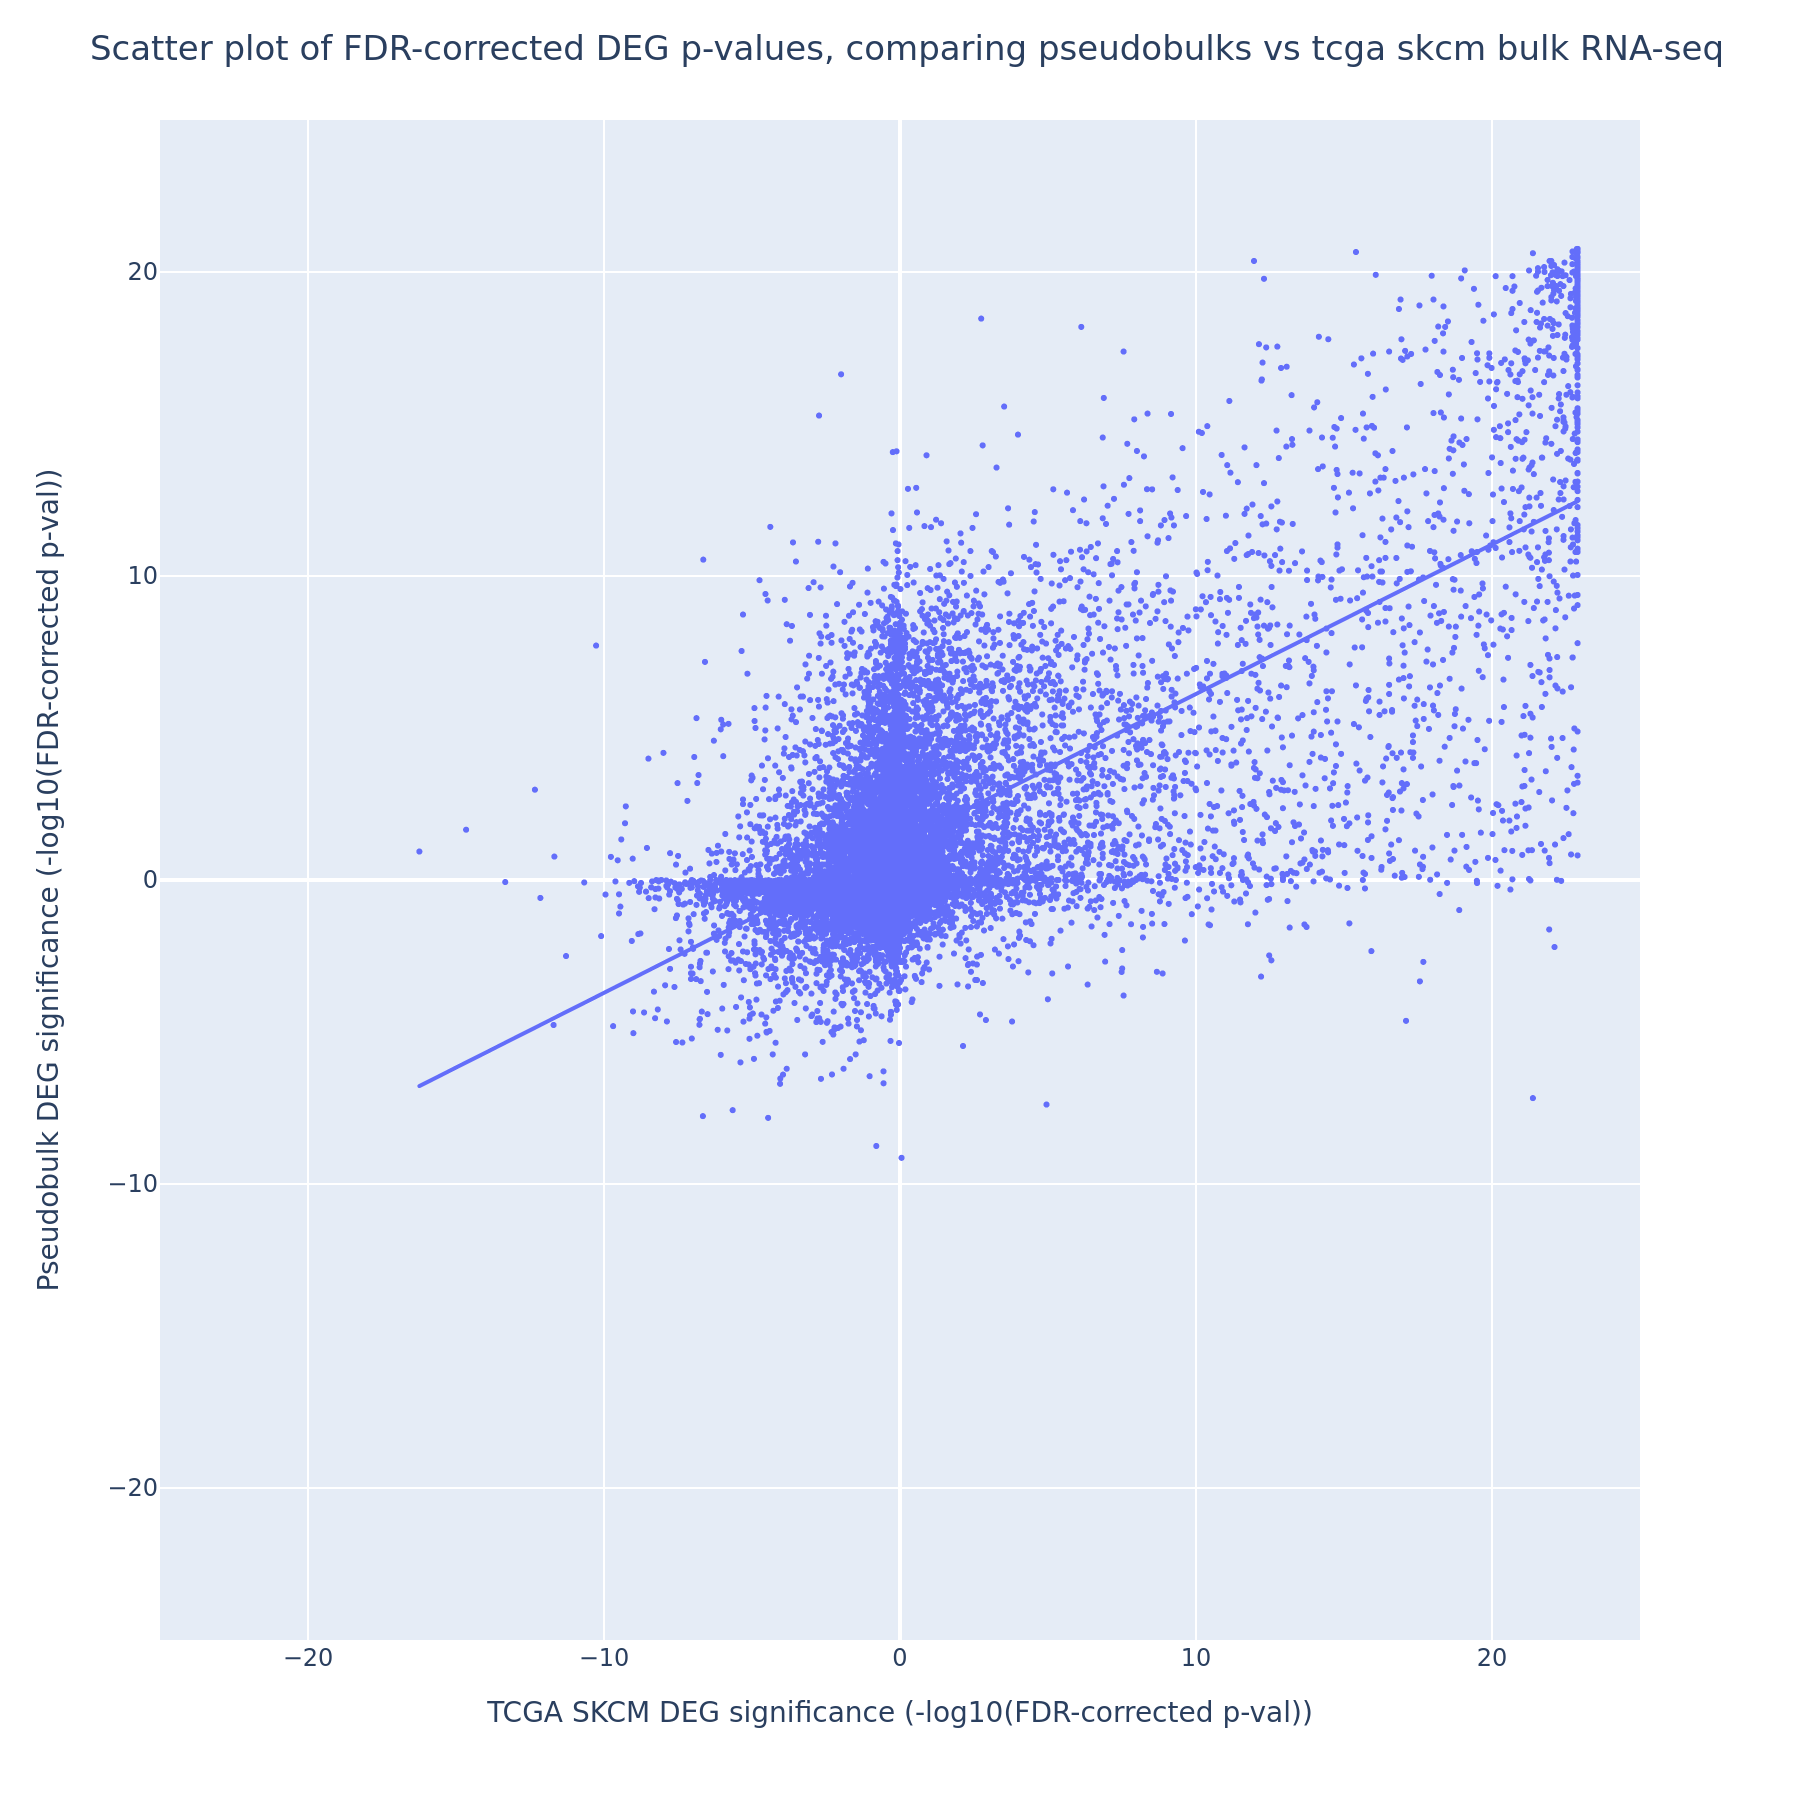

In [23]:
importlib.reload(deg_analysis)

fig = deg_analysis.make_scatter_of_signed_pvals(
    df_gene_stats_tcga_skcm, df_gene_stats_pseudobulks
)

fig.update_layout(
    title="Scatter plot of FDR-corrected DEG p-values, comparing pseudobulks vs tcga skcm bulk RNA-seq",
    xaxis_title="TCGA SKCM DEG significance (-log10(FDR-corrected p-val))",
    yaxis_title="Pseudobulk DEG significance (-log10(FDR-corrected p-val))",
)

fig.show(renderer="png", scale=2, width=900, height=900)

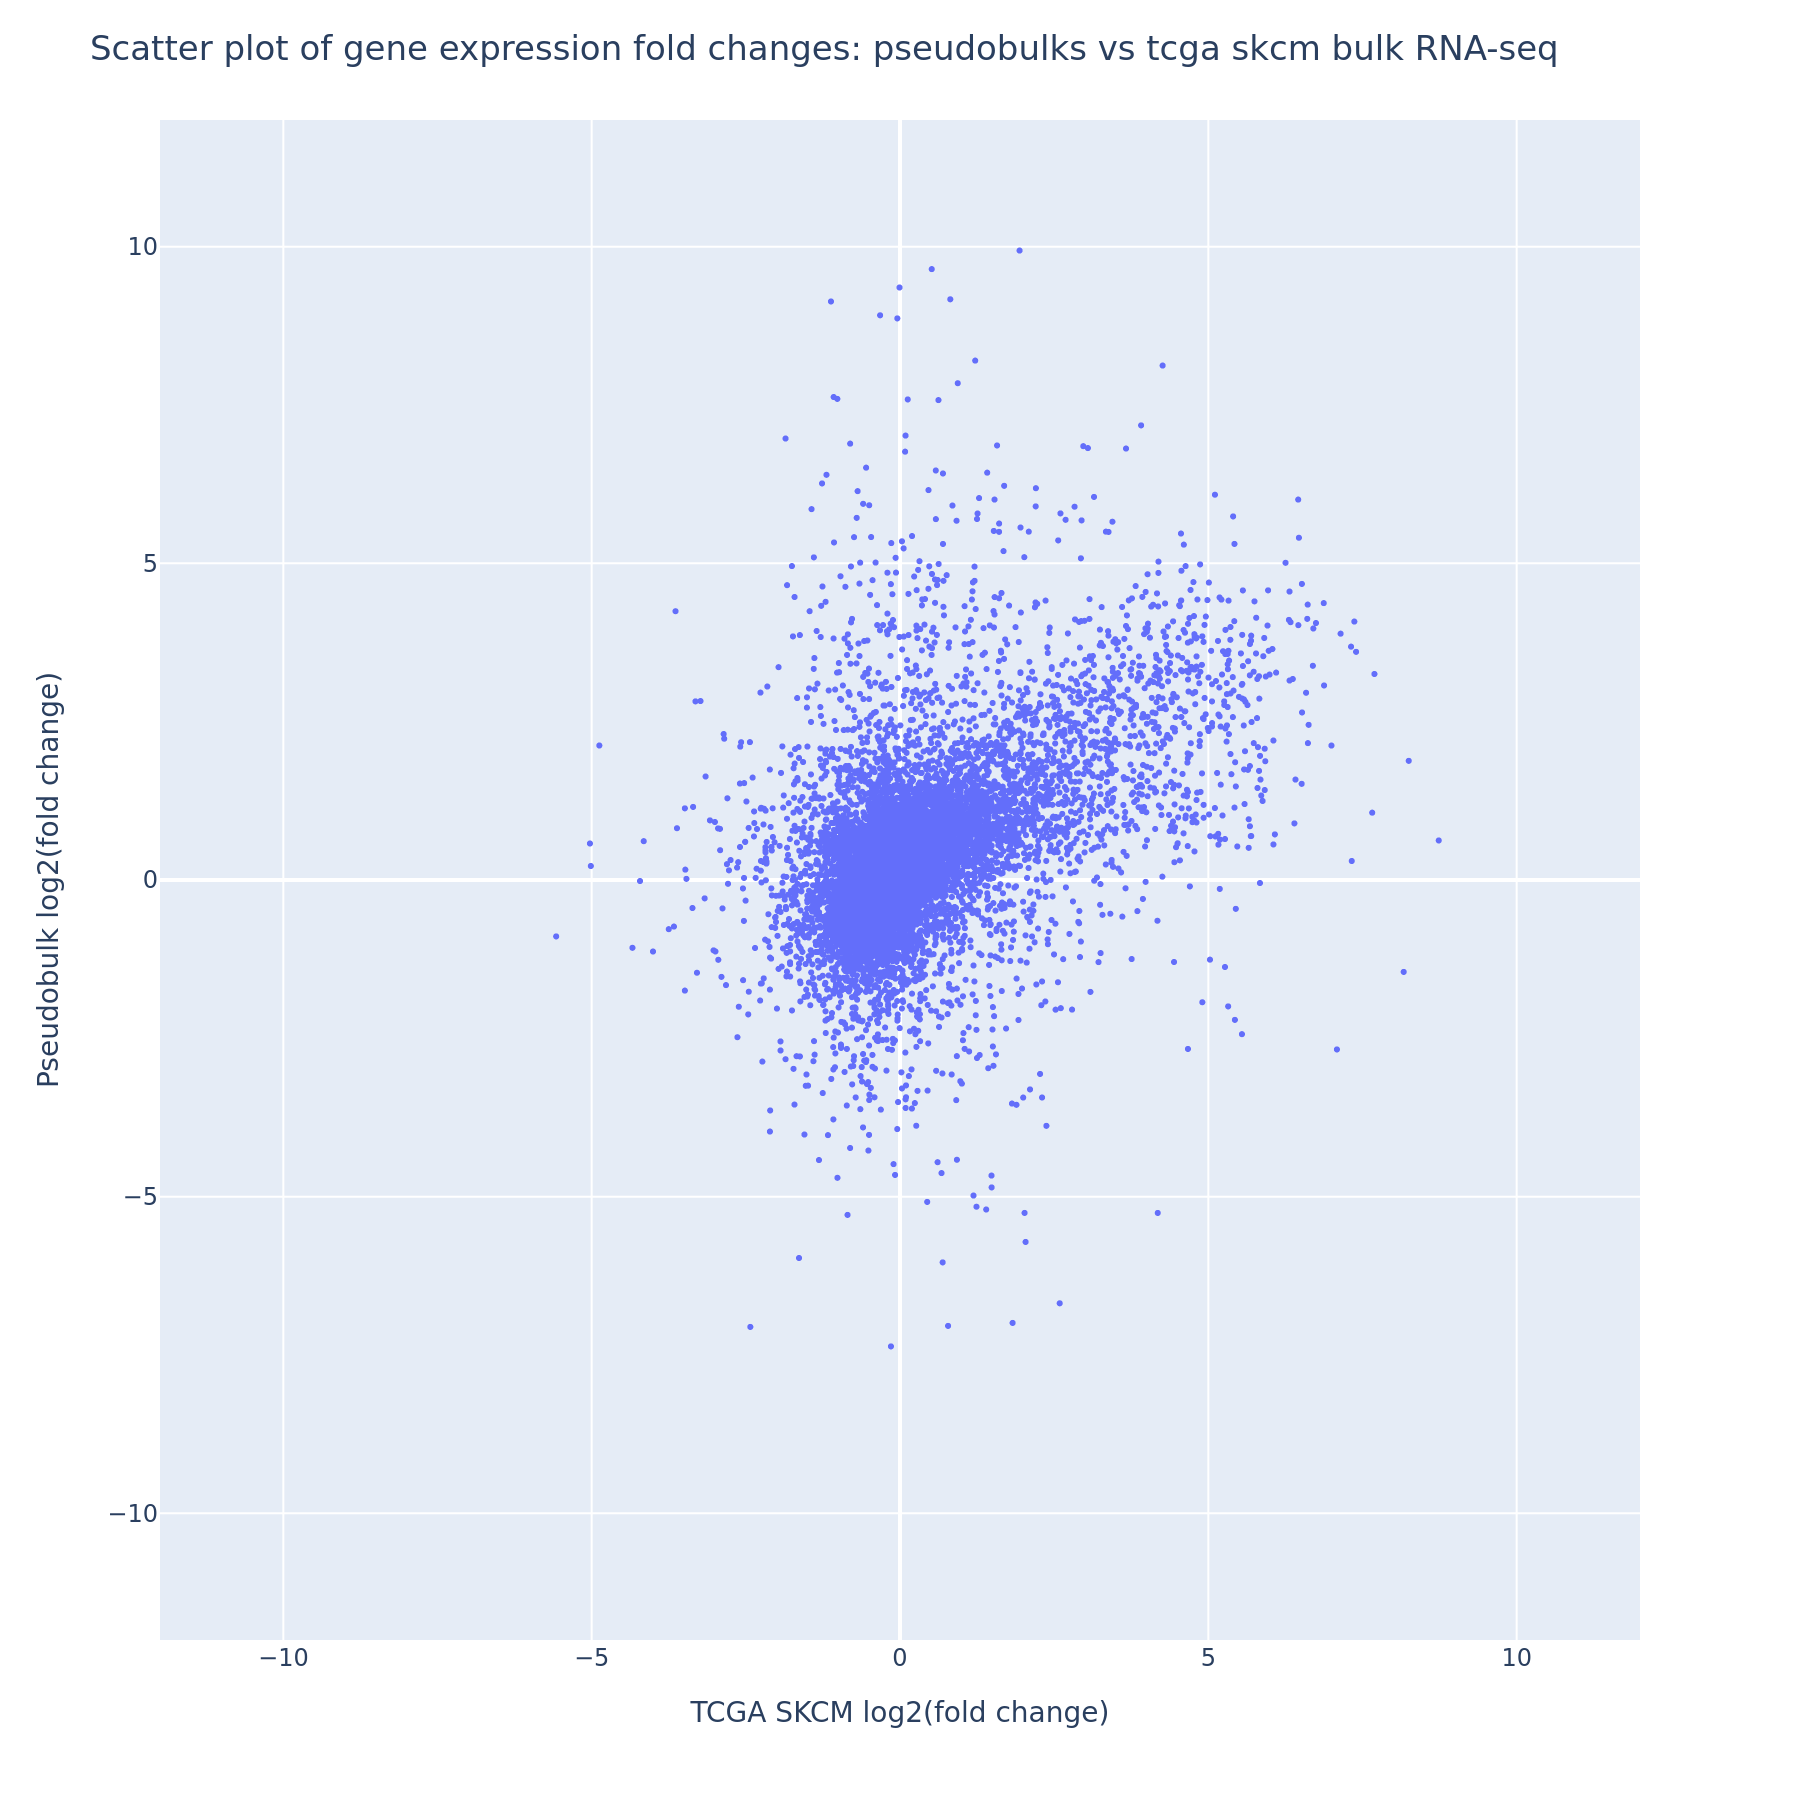

In [24]:
importlib.reload(deg_analysis)

fig = deg_analysis.make_scatter_of_log2_fold_changes(
    df_gene_stats_tcga_skcm, df_gene_stats_pseudobulks
)

fig.update_layout(
    title="Scatter plot of gene expression fold changes: pseudobulks vs tcga skcm bulk RNA-seq",
    xaxis_title="TCGA SKCM log2(fold change)",
    yaxis_title="Pseudobulk log2(fold change)",
)

fig.show(renderer="png", scale=2, width=900, height=900)
# fig.show("browser")

# what's the overlap for significant genes between real, pseudo?

In [26]:
importlib.reload(deg_analysis)

TOP_FRACTION = 0.10

crosstab, odds_ratio, p_value = deg_analysis.analyze_gene_significance_overlap(
    df_gene_stats_tcga_skcm, df_gene_stats_pseudobulks, TOP_FRACTION
)
print(odds_ratio)
print(p_value, ", -log10:", -np.log10(p_value))
crosstab

27.959168979420852
0.0 , -log10: inf


significant_in_cohort_2  False  True
significant_in_cohort_1             
False                    13779   678
True                       676   930